# Time Series Basics

## Correlated Stock Prices

You're interested in the performance of a particular stock. You use the [autocorrelation function](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.autocorr.html) in Pandas to assess how autocorrelated your stock's values are.

Autocorrelation makes explicit the idea of temporal correlation we discussed previously. Suppose we wanted to see how correlated a stock's prices are with the immediately preceding day's stock prices. 

| Day | Price | Price with Lag = 1 | Price with Lag = 2 |
|-----|-------|--------------------|--------------------|
| 1   | 25    | NA                 | NA                 |
| 2   | 26    | 25                 | NA                 |
| 3   | 28    | 26                 | 25                 |
| 4   | 24    | 28                 | 26                 |
| 5   | 23    | 24                 | 28                 |

Autocorrelation with a lag of 1 will calculate the correlation between column "Price" and column "Price with Lag = 1." Autocorrelation with a lag of $k$ will calculate the correlation between stock price and the stock price of $k$ days before in a similar manner.

I build a loop that iterates through days (we'll assume our stock price is the closing price at every day) 1 to 365 to assess how correlated a stock price is with the stock price from $i$ days ago. (Sample code seen below.)

```
for i in range(1, 366):
    print(df[stock_prices].autocorr(lag=i))
```

#### 1. Suppose my highest values of autocorrelation are found when $i = 1, 7, 30, 365$. What do each of these suggest about the performance of this particular stock?

A: The stock price has some volality that looks to be cyclical in nature 

Stock prices vary quite rapidly. Looking at almost any plot of stock price over time, we'll see a very "wiggly" function that moves around erratically. Building a model for this can be difficult.

One way to "de-noise" or "smooth" this is to create a [moving average](http://www.investopedia.com/terms/m/movingaverage.asp) of stock prices. Suppose I wanted to create a moving average of stock prices across $k$ days. In this case, I create a new column that takes the current day and $k-1$ previous days (for $k$ total days) and average the stock prices of these days.

For example, I have a column of stock prices and a column associated with a moving average for three days. Then, my row for Day 5 includes the Day 5 stock price and the average of Day 3, Day 4, and Day 5 stock prices. 

| Day | Price | Moving Average k = 3 |
|-----|-------|----------------------|
| 1   | 25    | NA                   |
| 2   | 26    | NA                   |
| 3   | 28    | 26.33                |
| 4   | 24    | 26                   |
| 5   | 23    | 25                   |

#### 2.  As the number of periods $k$ increases, how do I expect my plotted curve to change?

A: It will be more smoothed out because the data points captured in the lag increases

#### 3. Suppose we use our moving average to predict values of the stock price. As $k$ increases, how is the bias of our predictions affected? 

A: The lag is increased, so the higher k goes the less accurate the current forecast will be

#### 4. As $k$ increases, how is the variance of our predictions affected?

A: Variance is decreased because the lagged avg price is not susceptible to as much volatility 

## Stock price exploration 

#### Using the `yfinance` package, download stock data from the past three years for a company you are interested in. 

In [2]:
# pip install yfinance

In [3]:
import yfinance as yf
import pandas as pd
import matplotlib as plt

In [4]:
df = yf.download('SNAP', start="2017-03-02", end="2020-03-02")

[*********************100%***********************]  1 of 1 completed


#### Examine the data.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 754 entries, 2017-03-02 to 2020-02-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       754 non-null    float64
 1   High       754 non-null    float64
 2   Low        754 non-null    float64
 3   Close      754 non-null    float64
 4   Adj Close  754 non-null    float64
 5   Volume     754 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 41.2 KB


In [6]:
df.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-03-02,24.000000,26.049999,23.500000,24.48,24.48,217048900
2017-03-03,26.389999,29.440001,26.059999,27.09,27.09,148166400


#### We'll be working with the 'Adj Close' column. Rename that column 'price' and make your DataFrame just that column and the datetime index. 

In [7]:
df.rename(columns={'Adj Close' : "price"}, inplace=True )

In [8]:
df_small = df['price']

#### Make a column that is the `price` of the previous day.

In [9]:
df_small = pd.DataFrame(df_small)

In [10]:
df_small['lag_1'] = df_small['price'].shift(1)

In [11]:
df_small

,price,lag_1
Date,,
2017-03-02,24.480000,NaN
2017-03-03,27.090000,24.480000
2017-03-06,23.770000,27.090000
2017-03-07,21.440001,23.770000
2017-03-08,22.809999,21.440001
...,...,...
2020-02-24,16.150000,16.700001
2020-02-25,15.890000,16.150000
2020-02-26,15.670000,15.890000


#### Split the DataFrame into training and test sets so that the test set is the most recent year of data (you can use pandas slicing, scikit-learn, or sktime packages to do this).

In [12]:
train = df_small.loc['2017-03-02':'2019-03-02']
test = df_small.loc['2019-03-03': '2020-03-03'] 

#### Plot the stock price with different colors for the training and test sets.

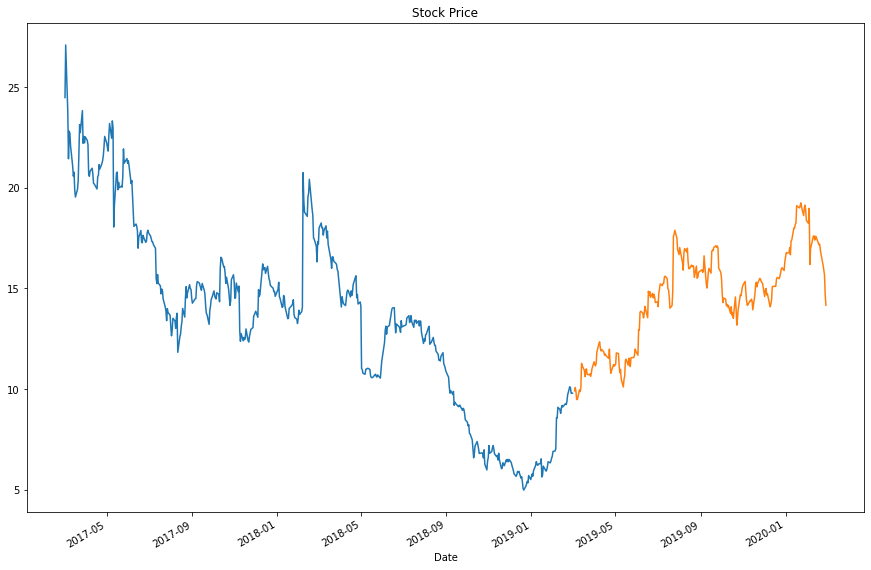

In [13]:
train['price'].plot()
test['price'].plot(figsize=(15,10), title='Stock Price');

#### Find the autocorrelation of the training data.

In [14]:
train['price'].autocorr()

0.990706424091793

#### Plot the autocorrelation using statsmodels `plot_acf`.

In [15]:
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


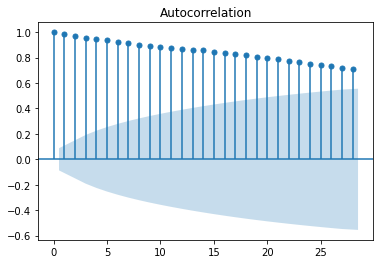

In [16]:
plot_acf(train['price']);

#### Plot the partial autocorrelation values using statsmodels `plot_pacf`.

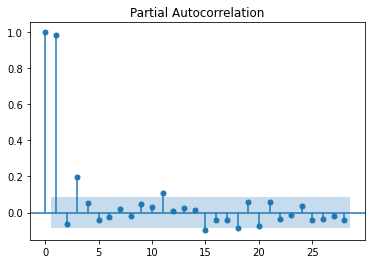

In [17]:
plot_pacf(train['price']);

#### Do any values show high autocorrelation?

yes, the first two lollipop sticks have high ac

#### Make a baseline model that is just the last value from the training set.

In [18]:
df_preds = test.copy()

In [19]:
df_preds['last'] = train['price'].iloc[-1]

In [20]:
df_preds

,price,lag_1,last
Date,,,
2019-03-04,9.92,9.800000,9.8
2019-03-05,10.08,9.920000,9.8
2019-03-06,9.87,10.080000,9.8
2019-03-07,9.49,9.870000,9.8
2019-03-08,9.48,9.490000,9.8
...,...,...,...
2020-02-24,16.15,16.700001,9.8
2020-02-25,15.89,16.150000,9.8
2020-02-26,15.67,15.890000,9.8


In [21]:
from sklearn.metrics import mean_absolute_error as mae
import numpy as np

#### Score it on the test set using MAE

In [22]:
mae_base = mae(test['price'], df_preds['last'])
mae_base = np.round(mae_base, 2)
mae_base

4.74

#### Using scikit-learn's LinearRegression class, make a model to predict the stock price based on the stock price from the day before.

In [23]:
from sklearn.linear_model import LinearRegression

In [ ]:
train

In [54]:
X = train['lag_1'][1:].values.reshape(1,-1)
y = train['price'].values.reshape(1,-1)

In [55]:
X

array([[24.47999954, 27.09000015, 23.77000046, 21.44000053, 22.80999947,
        22.70999908, 22.06999969, 21.09000015, 20.57999992, 20.77000046,
        19.88999939, 19.54000092, 19.93000031, 20.37999916, 21.81999969,
        23.12999916, 22.73999977, 23.82999992, 22.20999908, 22.54999924,
        22.22999954, 22.53000069, 22.35000038, 22.13999939, 20.70000076,
        20.56999969, 20.81999969, 20.96999931, 20.70000076, 20.21999931,
        20.19000053, 19.94000053, 20.54999924, 20.62000084, 21.14999962,
        20.93000031, 21.20000076, 21.34000015, 21.57999992, 22.01000023,
        22.54999924, 22.20999908, 21.98999977, 21.81999969, 22.59000015,
        23.19000053, 22.45999908, 23.31999969, 22.97999954, 18.04999924,
        19.13999939, 20.73999977, 20.78000069, 19.89999962, 20.27000046,
        20.        , 20.07999992, 20.03000069, 20.53000069, 21.93000031,
        21.21999931, 21.45000076, 21.20999908, 21.34000015, 21.09000015,
        20.20999908, 20.36000061, 19.55999947, 18.8

In [52]:
X.values

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [56]:
lr = LinearRegression()

In [57]:
lr.fit(X,y)

LinearRegression()

#### Predict, plot, and score on MAE.

In [61]:
y_preds = lr.predict(X)

In [62]:
plt.plot(X, y_preds)

AttributeError: module 'matplotlib' has no attribute 'plot'

In [60]:
mae(X, y_preds)

ValueError: y_true and y_pred have different number of output (502!=503)

#### How does the model do?

#### Congratulations! You just made an autoregression model (AR)! 🎉